In [6]:
import sys
sys.path.append("..")

import torch
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import pickle

from utils import get_dataloaders, show_anns
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [2]:
# sam_checkpoint = "sam_vit_h_4b8939.pth"
# model_type = "vit_h"
sam_checkpoint = "../models/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# mask_generator = SamAutomaticMaskGenerator(sam, stability_score_thresh=0., pred_iou_thresh=0.)
mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=16)

In [3]:
image_net_loader = get_dataloaders('/mnt/hdd/datasets/imagenet', normalize=False)

In [4]:
# iterate over image net dataset
N = 1000

masks_all = []
cos_sim_all = []
for i, (images, labels) in tqdm(enumerate(image_net_loader)):
    
    image = images.squeeze(0).transpose(0, 1).transpose(1, 2).numpy()
    image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    image = image.astype(np.uint8)    
    
    masks = mask_generator.generate(image)
    masks_all.append(len(masks))
    cos_sim_all.append(mask_generator.predictor.h_cos_sim.detach().cpu().numpy())

    if i >= N:
        break


    

1000it [20:27,  1.23s/it]


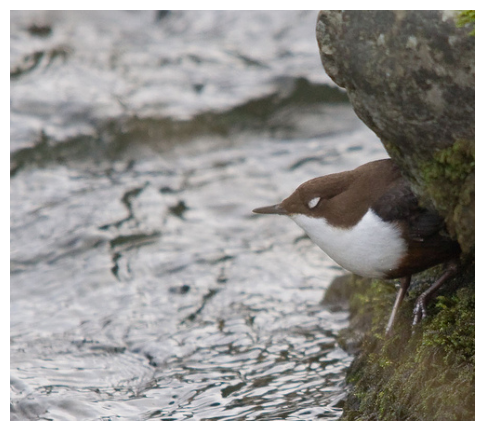

In [13]:
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')
plt.show()

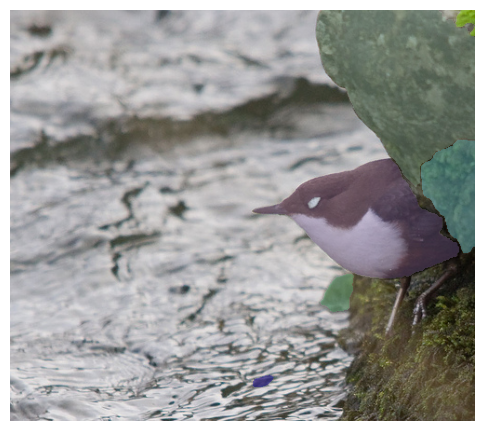

In [14]:
plt.figure(figsize=(6,6))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [7]:
# save masks_all and cos_sim_all as pickle files
with open(f"outputs/image_net_masks_all.pkl", "wb") as f:
    pickle.dump(masks_all, f)

with open(f"outputs/image_net_cos_sim_all.pkl", "wb") as f:
    pickle.dump(cos_sim_all, f)

In [15]:
# read pickle files
with open(f"outputs/image_net_masks_all.pkl", "rb") as f:
    masks_all = pickle.load(f)

with open(f"outputs/image_net_cos_sim_all.pkl", "rb") as f:
    cos_sim_all = pickle.load(f)

# 1) Correlation between hidden state saturation and nr. of masks

Findings:
- hidden state saturation (in terms of average cosine similarity between layers) and nr. of masks (in the output of the full SAM model) do NOT seem to be very correlated. correlation coefficient at every layer is 0.1 usually

In [27]:
N, L = len(cos_sim_all), len(cos_sim_all[0])
print(N, L)

h_sat = [cos_sim_all[n].mean() for n in range(len(cos_sim_all))]
h_sat_l = [[cos_sim_all[n][l].min() for n in range(len(cos_sim_all))] for l in range(L)]

1001 11


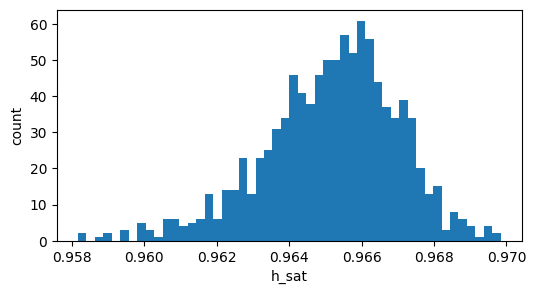

In [20]:
# plot histogram of h_sat
plt.figure(figsize=(6,3))
plt.hist(h_sat, bins=50)
plt.xlabel("h_sat")
plt.ylabel("count")
plt.show()

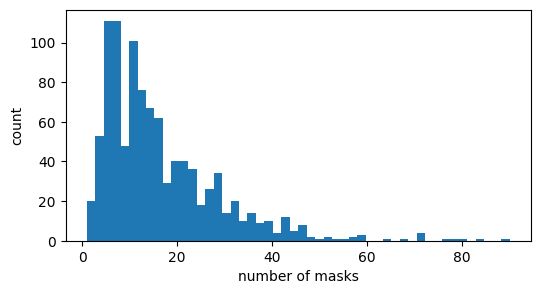

In [21]:
# plot histogram of number of masks
plt.figure(figsize=(6,3))
plt.hist(masks_all, bins=50)
plt.xlabel("number of masks")
plt.ylabel("count")
plt.show()

[[1.         0.26861598]
 [0.26861598 1.        ]]


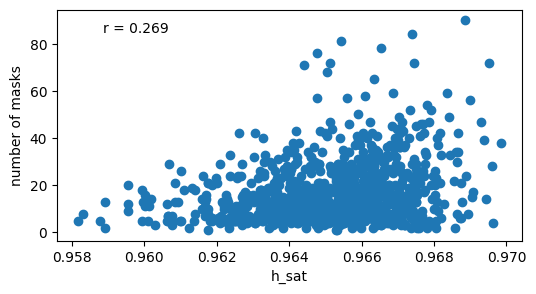

In [36]:
# plot a scatter plot of h_sat vs number of masks
plt.figure(figsize=(6,3))
plt.scatter(h_sat, masks_all)
plt.xlabel("h_sat")
plt.ylabel("number of masks")
# add text box with correlation coefficient
plt.text(0.1, 0.9, f"r = {np.corrcoef(h_sat, masks_all)[0,1]:.3f}", transform=plt.gca().transAxes)
plt.show()

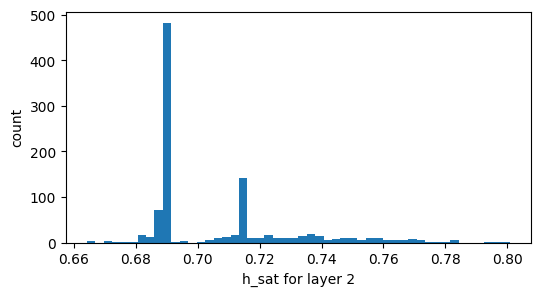

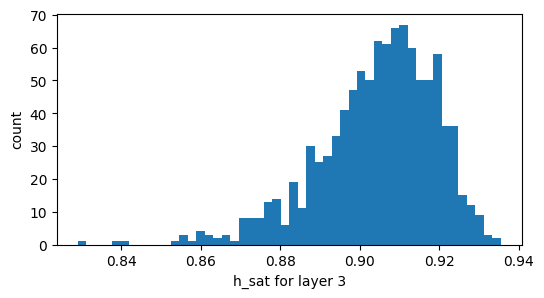

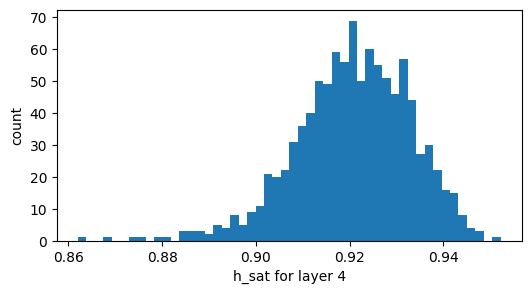

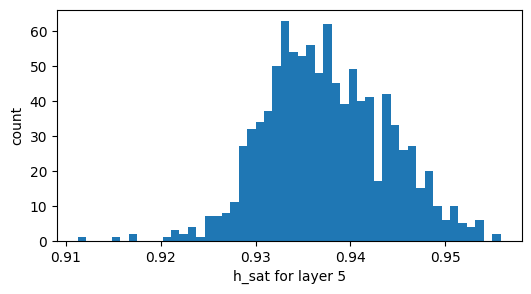

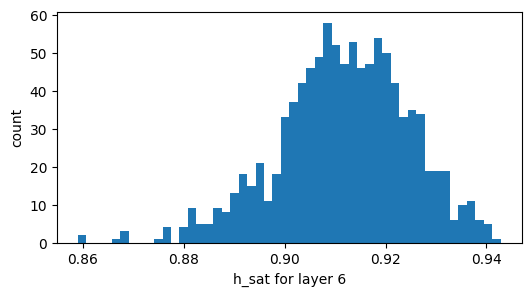

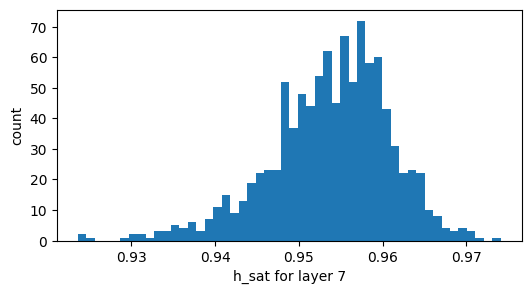

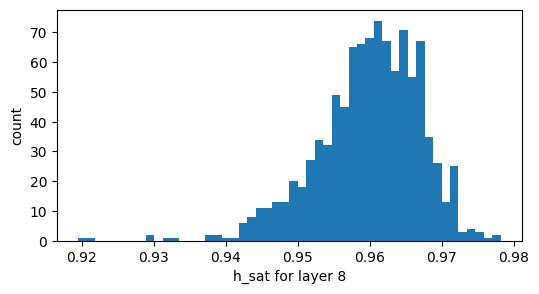

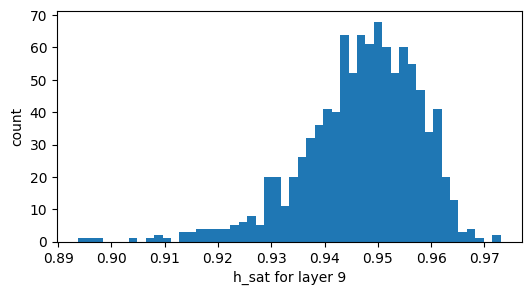

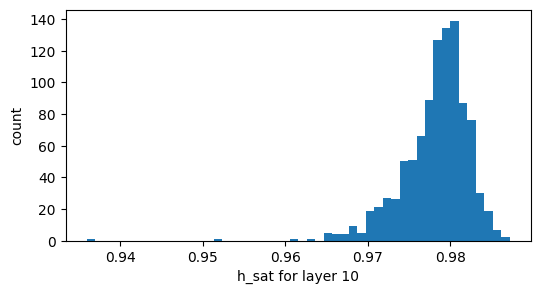

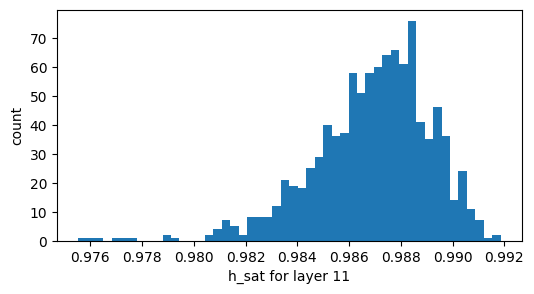

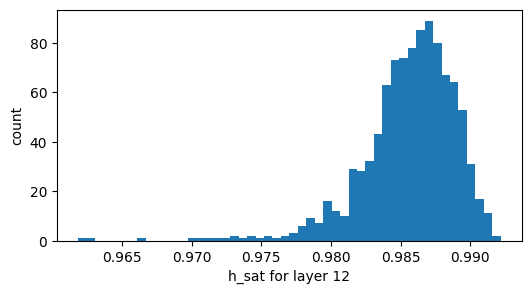

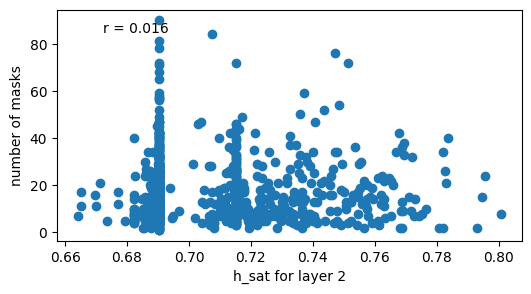

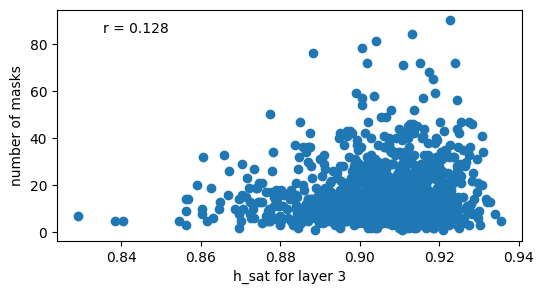

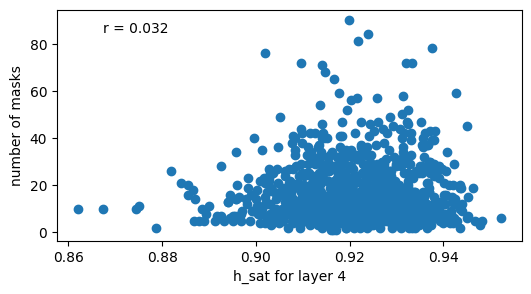

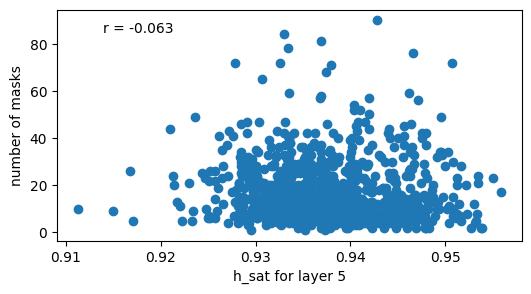

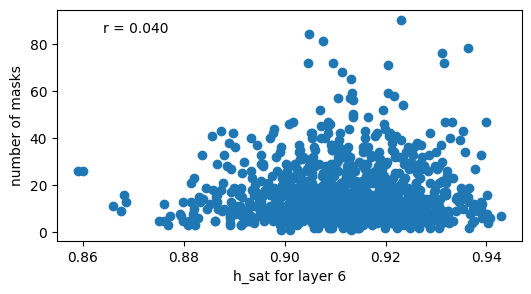

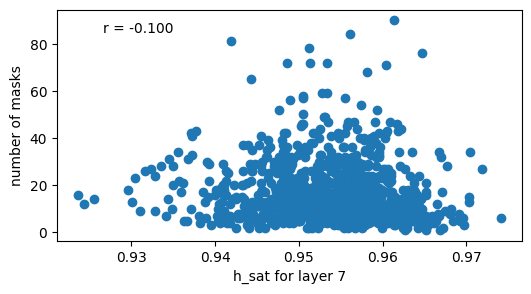

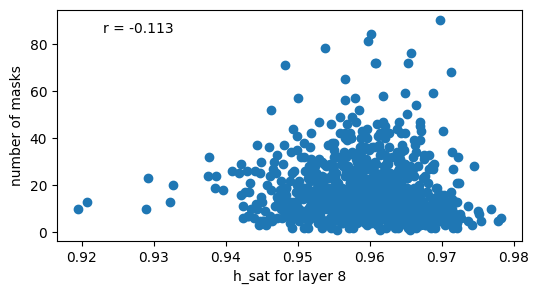

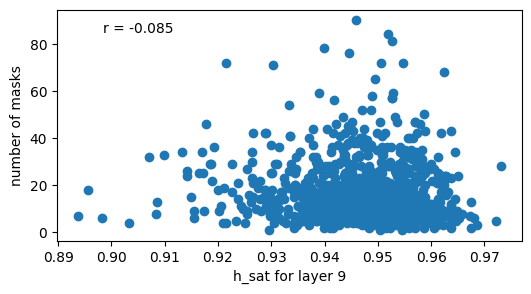

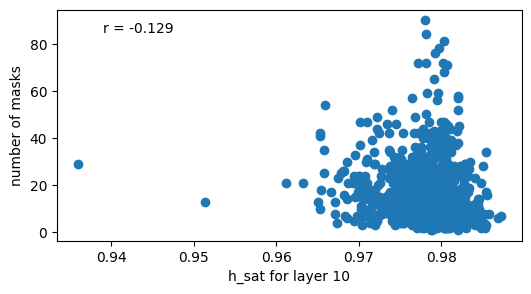

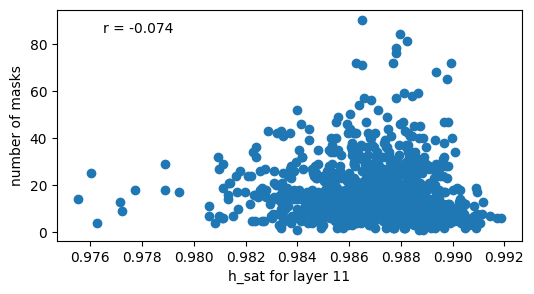

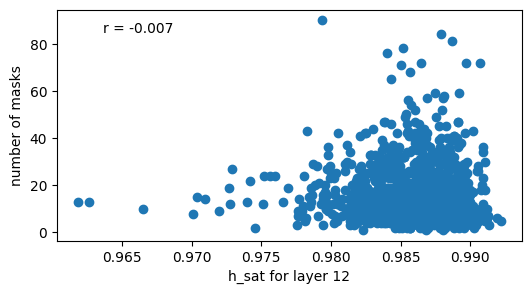

In [38]:
for l in range(L):
    plt.figure(figsize=(6,3))
    plt.hist(h_sat_l[l], bins=50)
    plt.xlabel(f"h_sat for layer {l + 2}")
    plt.ylabel("count")
    plt.show()

for l in range(L):
    plt.figure(figsize=(6,3))
    plt.scatter(h_sat_l[l], masks_all)
    plt.xlabel(f"h_sat for layer {l + 2}")
    plt.ylabel("number of masks")
    plt.text(0.1, 0.9, f"r = {np.corrcoef(h_sat_l[l], masks_all)[0,1]:.3f}", transform=plt.gca().transAxes)
    plt.show()

# 2) Hidden state saturation analysis

Findings:

- saturation of hidden states (in terms of cosine similarity) tend to have very similar trajectories across layers for all the data points
- that implies 2 things:
    - hidden state saturation might not be the best measure if we want to distinguish easy and hard images
    - using the same thershold at every layer will not be sensible, having a separate lambda for each layer probably makes more sense

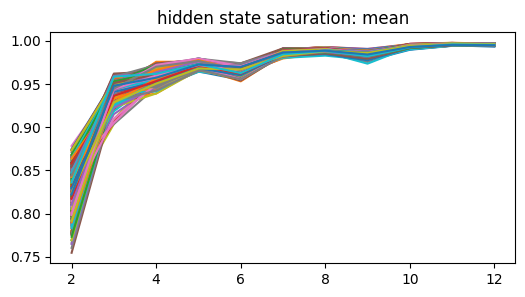

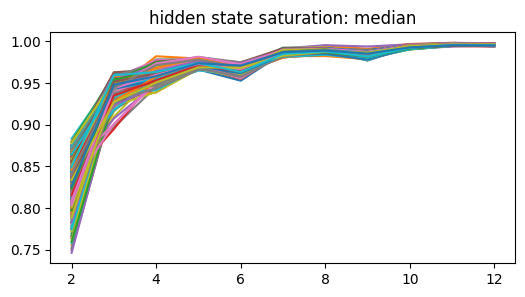

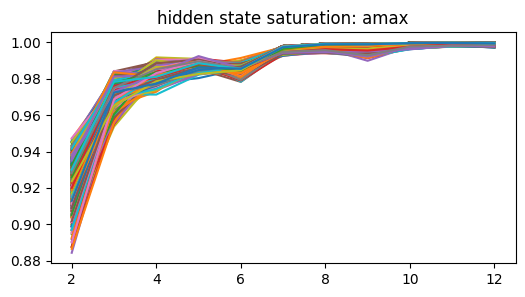

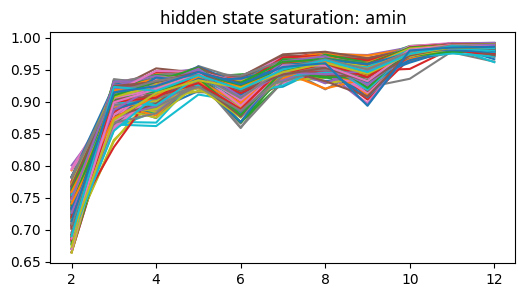

In [45]:
for agg_fun in [np.mean, np.median, np.max, np.min]:
    plt.figure(figsize=(6,3))
    for n in range(len(cos_sim_all)):
        plt.plot([l for l in range(2, L + 2)], agg_fun(cos_sim_all[n], axis=(1, 2, 3)))
    plt.title(f"hidden state saturation: {agg_fun.__name__}")
    plt.show()


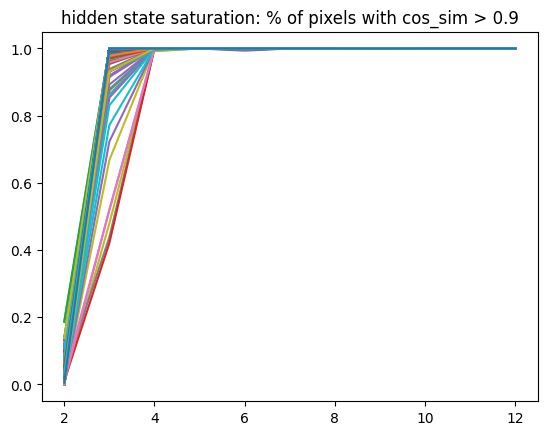

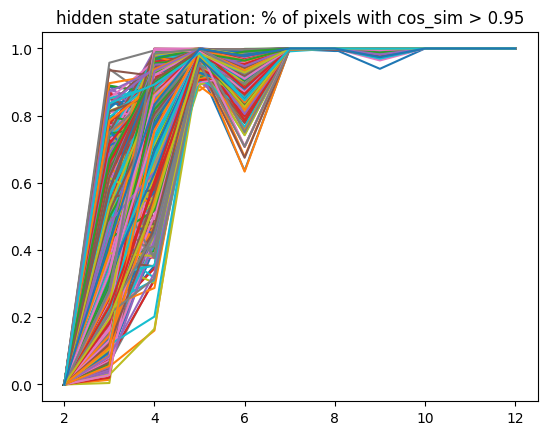

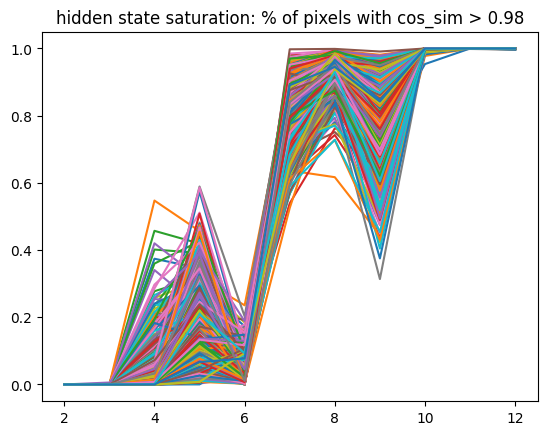

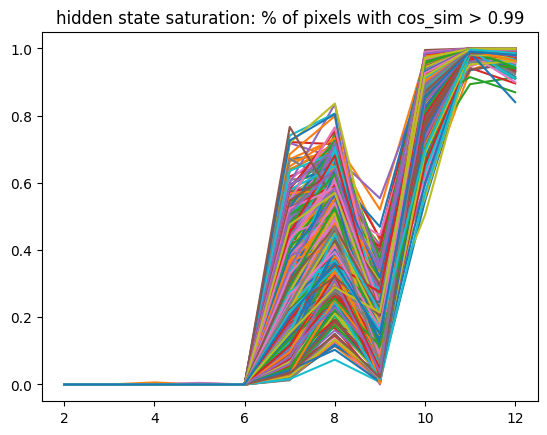

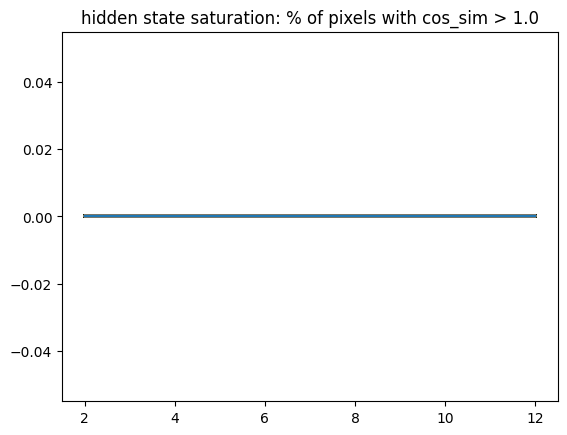

In [46]:
for pixel_thres in [0.9, 0.95, 0.98, 0.99, 1.]: 
    for n in range(len(cos_sim_all)):
        plt.plot([l for l in range(2, L + 2)], (cos_sim_all[n] > pixel_thres).mean(axis=(1,2,3)))
    plt.title(f'hidden state saturation: % of pixels with cos_sim > {pixel_thres}')
    plt.show()

# 3) Hidden state saturation threshold

Findings:

- hard to find a saturation threshold that would "spread out" datapoints between different layers/exits. for a given threshold, usually, all the datapoints exit at the same one or two layers
    - somewhat suprisingly, using dynamic thresholding (i.e., having a separate threshold per exit) does not help much with that, i.e., the concentration of datapoints at only a couple of exits is still there, see 3.2 below
- again, it doesn't seem to be the case that images with a smaller number of masks would exhibit earlier saturation compared to points with a larger number of masks


In [ ]:
def find_first_above_threshold(tensor, delta=[1.0], agg_type="mean"):
    if len(delta) == 1:
        delta = np.ones(len(tensor)) * delta[0]
    
    # Averaging the tensor over axis=0
    if agg_type == "mean":
        averaged_tensor = np.mean(tensor, axis=(1, 2, 3))
    elif agg_type == "min":
        averaged_tensor = np.min(tensor, axis=(1, 2, 3))
    else:
        raise NotImplementedError()

    # Finding the first element larger than delta
    for i in range(len(averaged_tensor)):
        if averaged_tensor[i] > delta[i]:
            return i + 1
    
    # Return 11 if no element is found
    return len(averaged_tensor) + 1

## 3.1) Single threshold

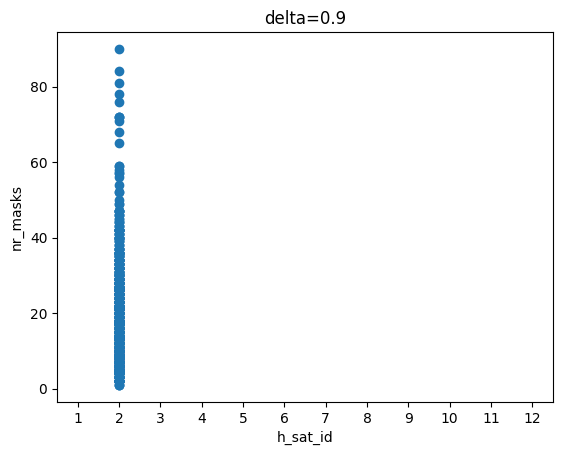

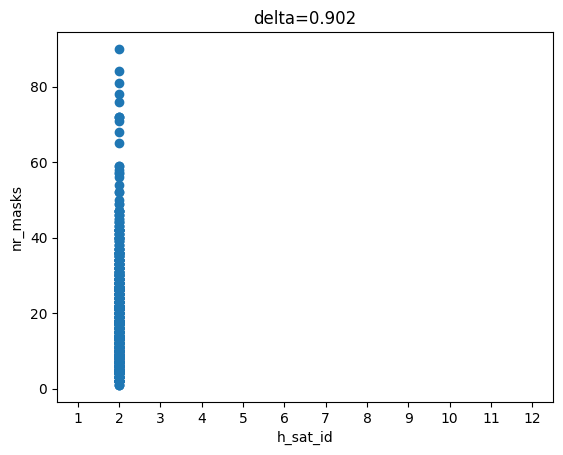

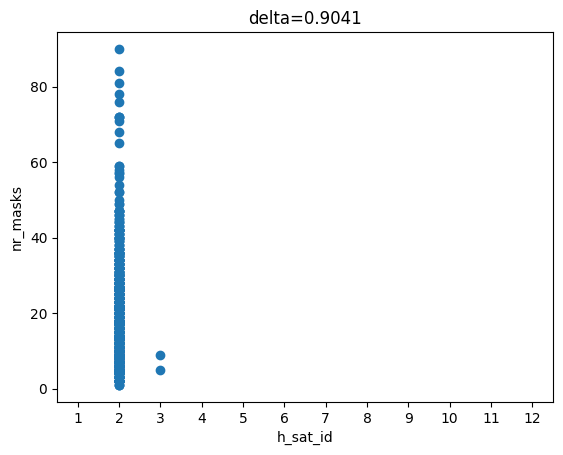

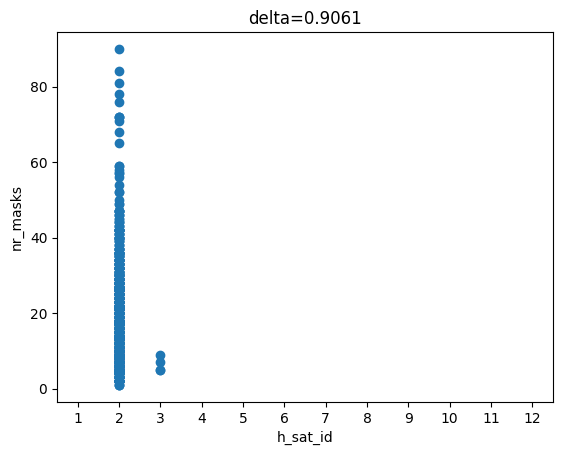

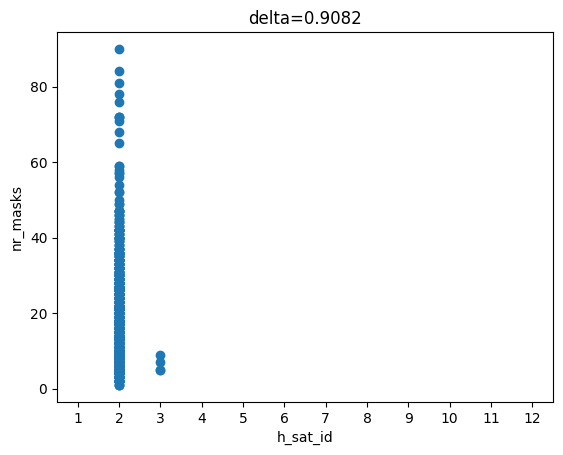

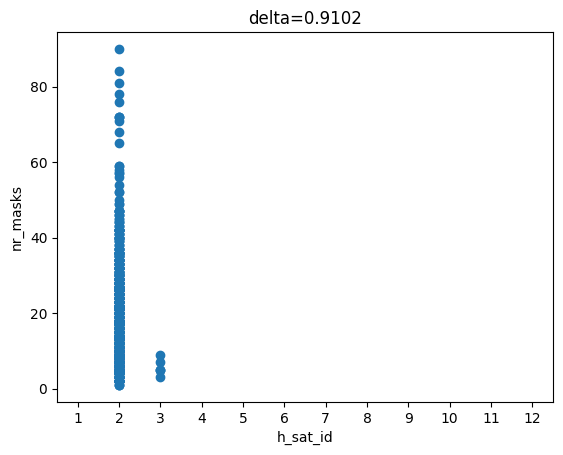

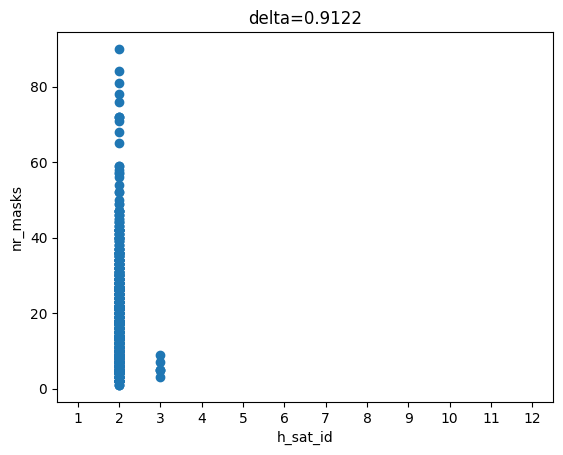

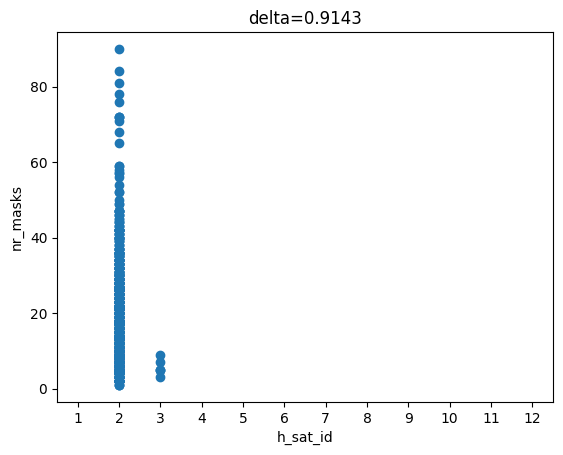

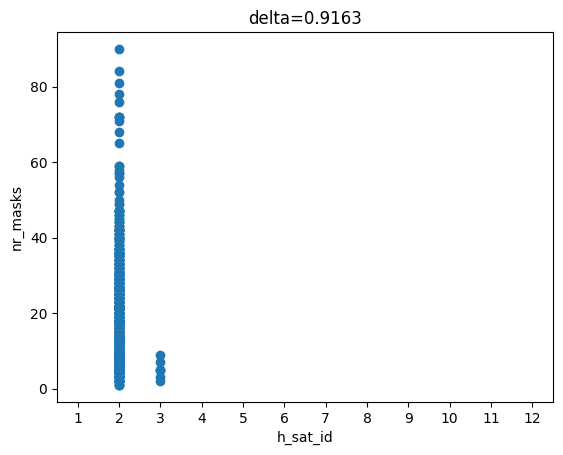

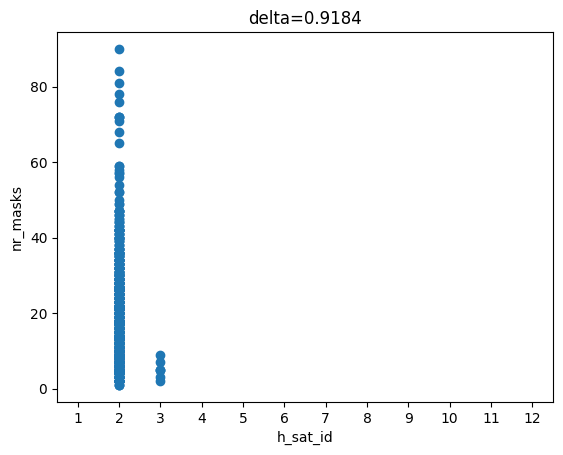

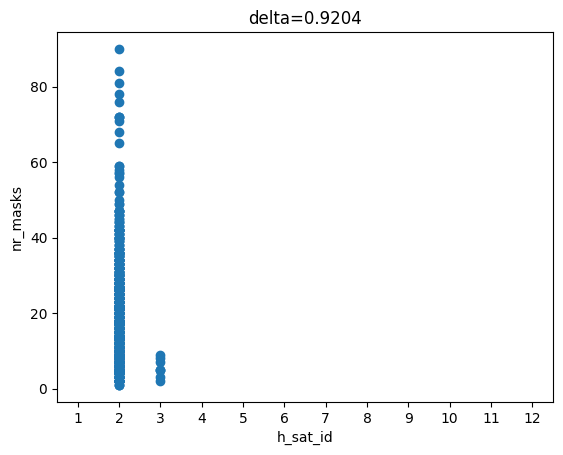

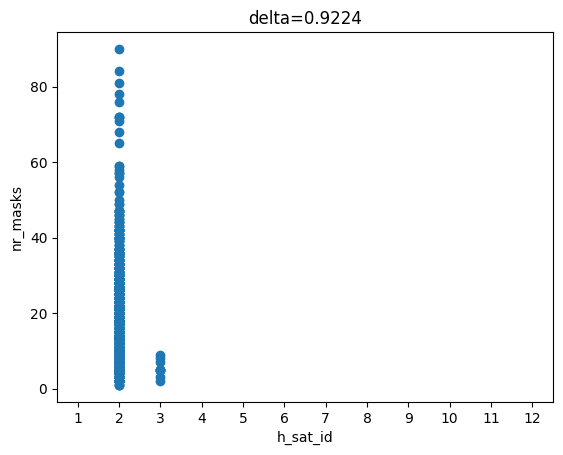

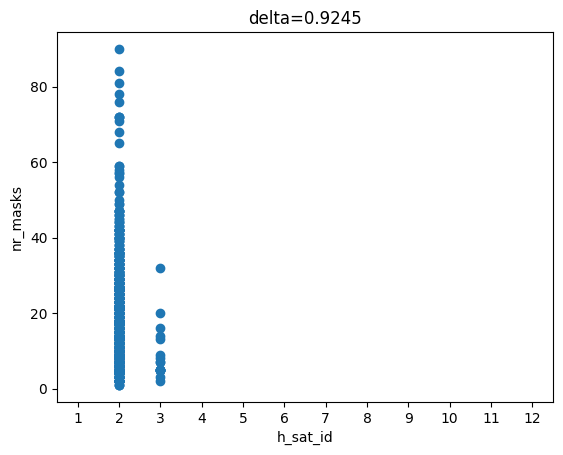

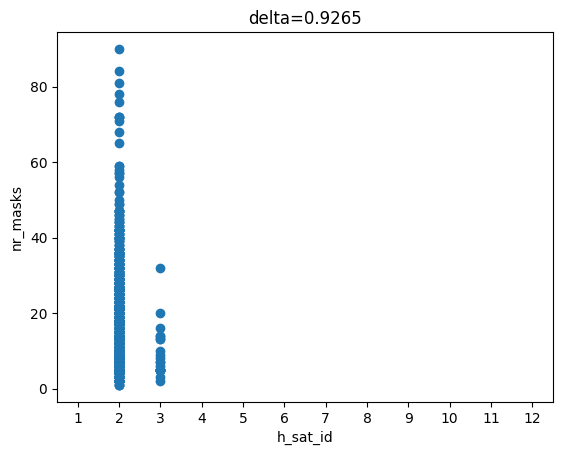

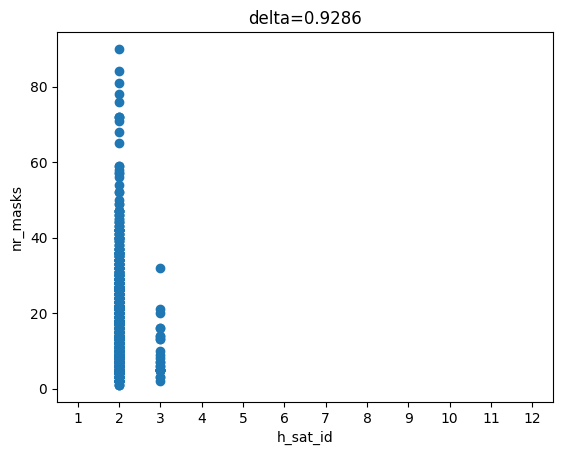

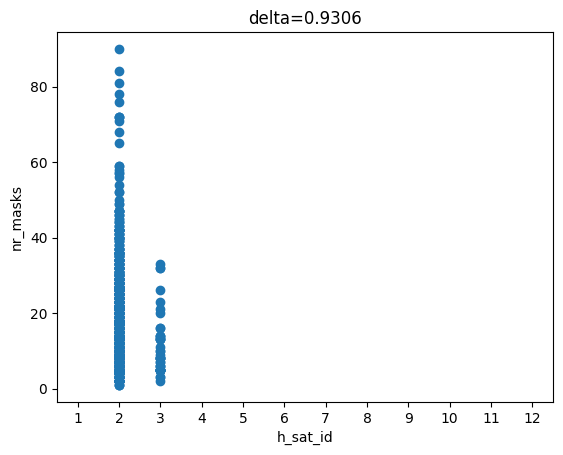

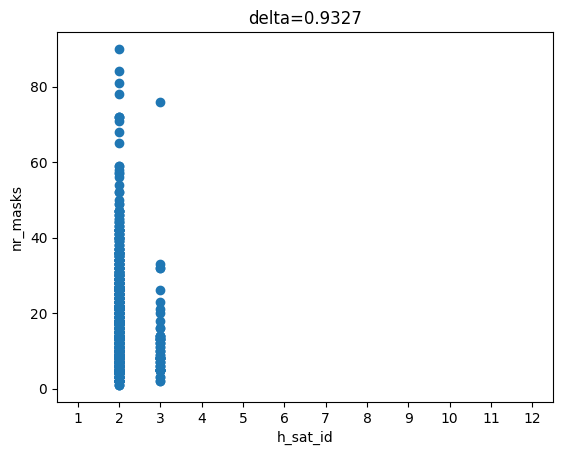

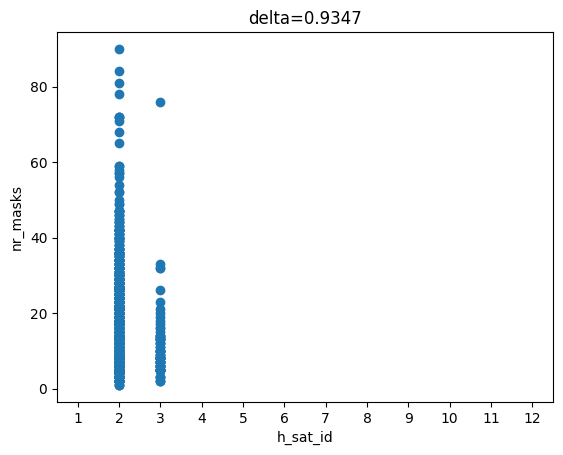

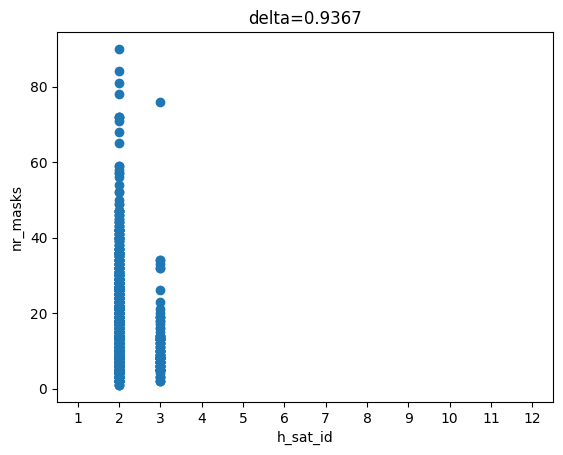

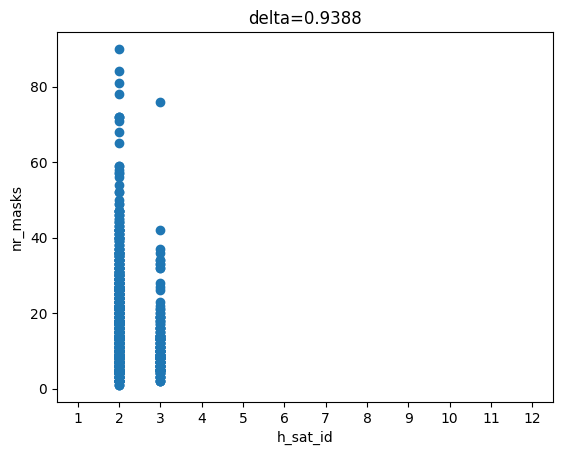

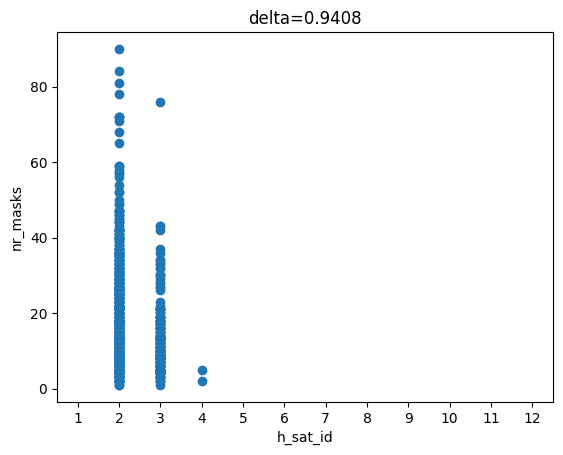

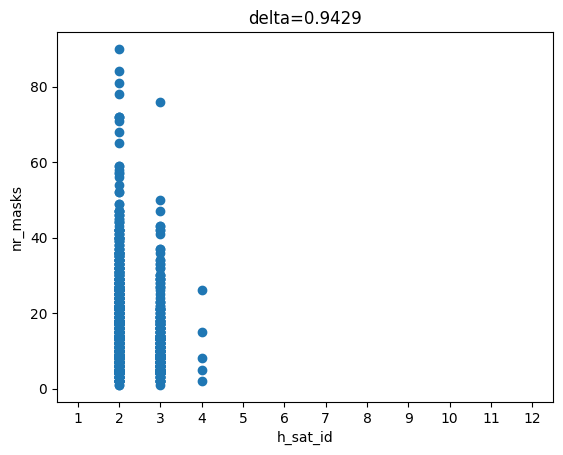

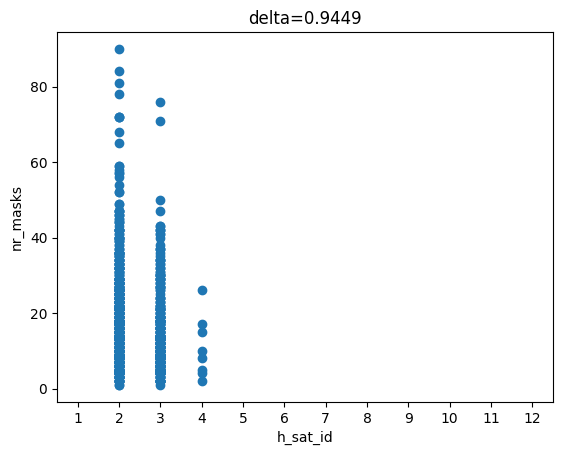

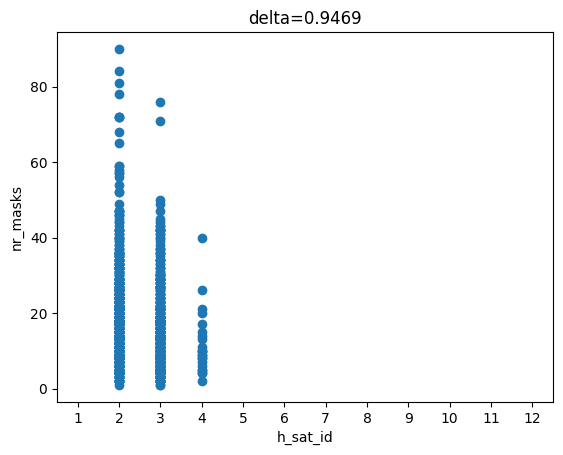

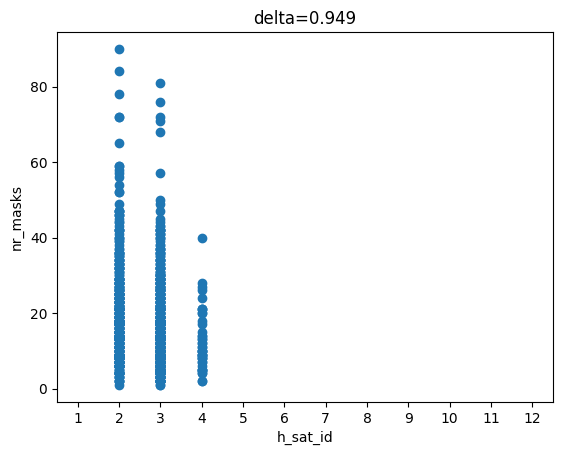

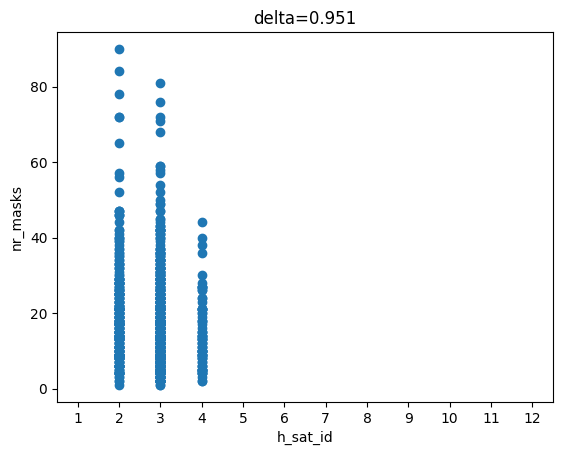

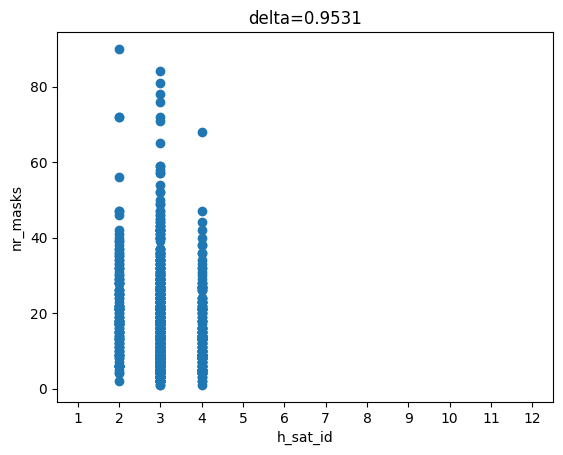

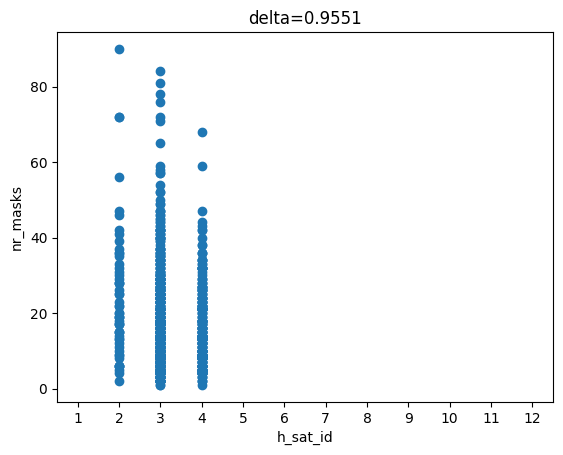

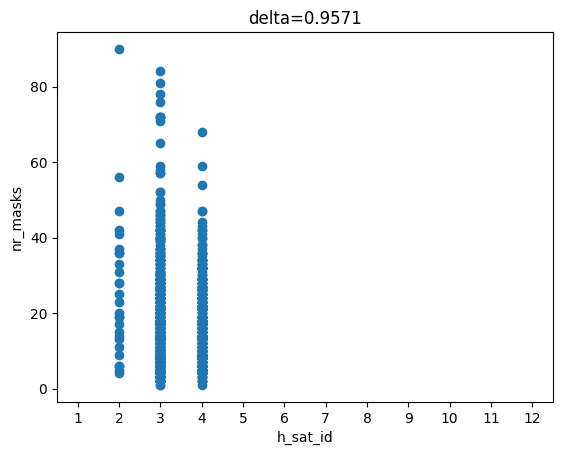

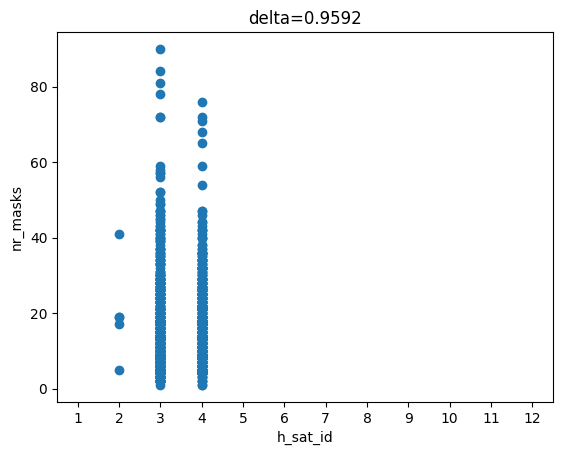

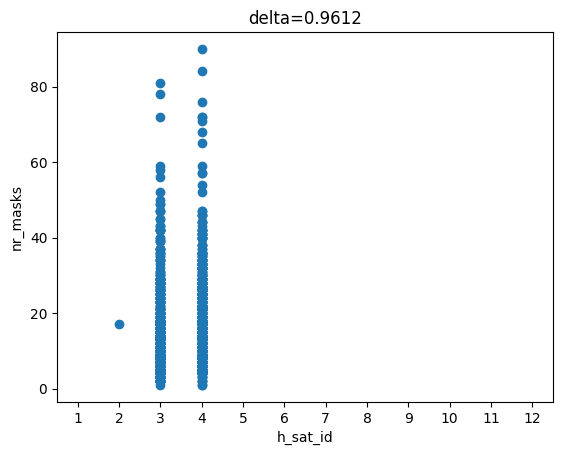

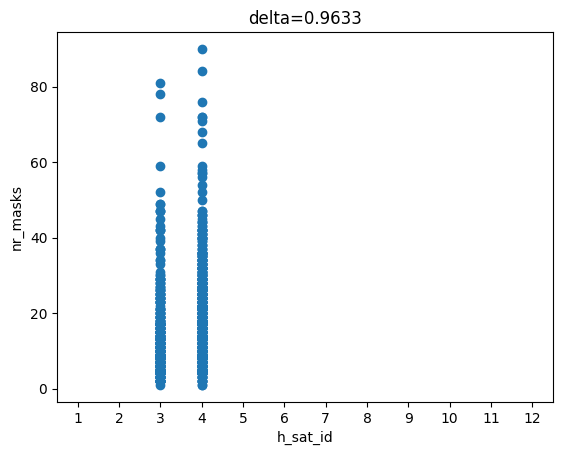

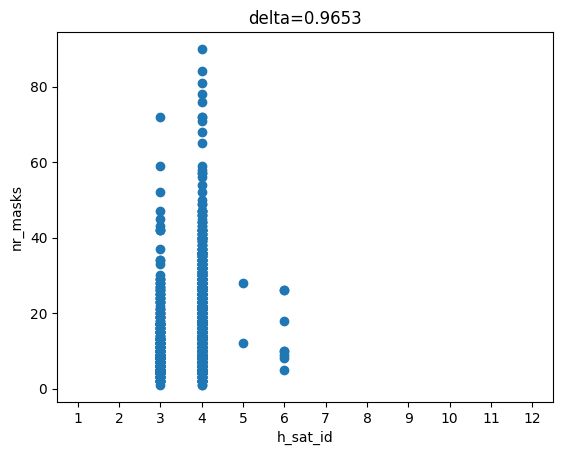

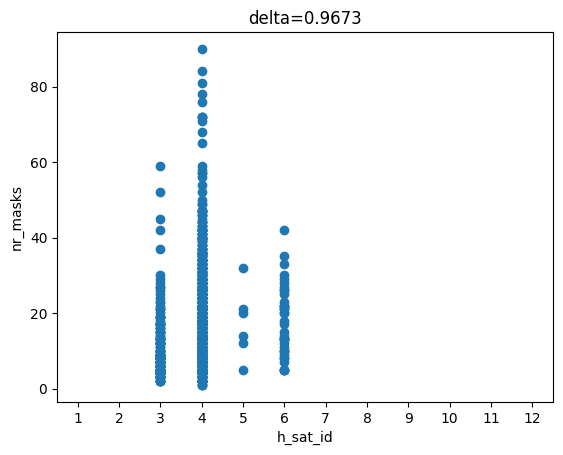

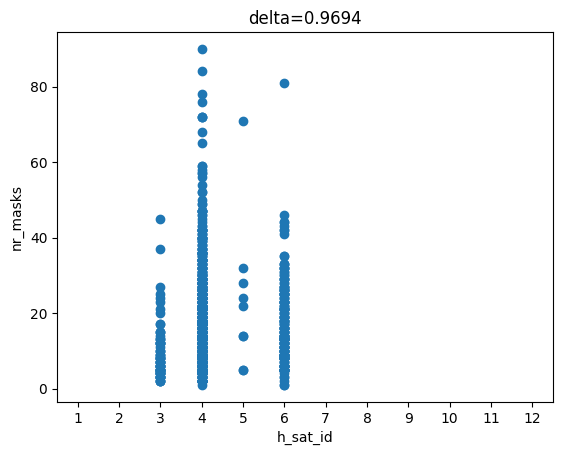

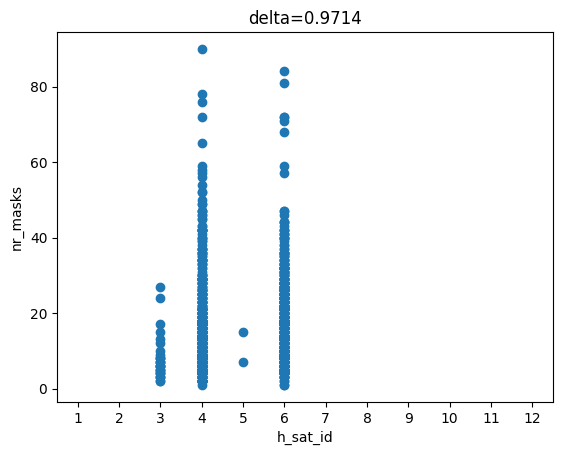

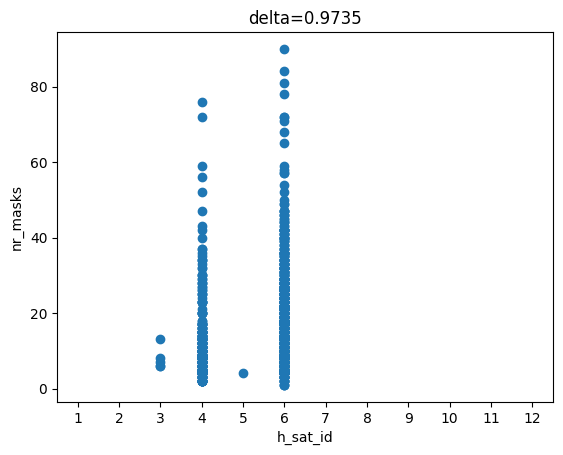

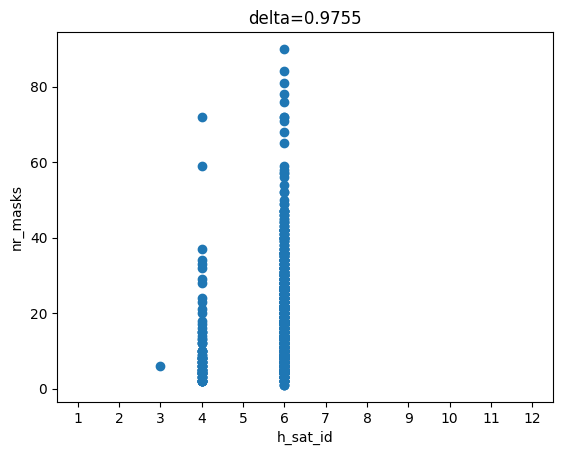

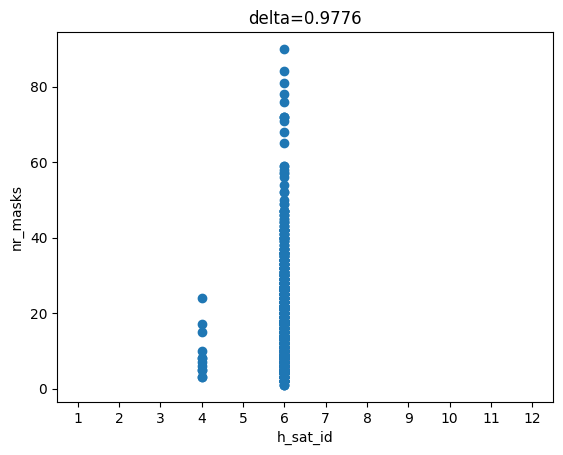

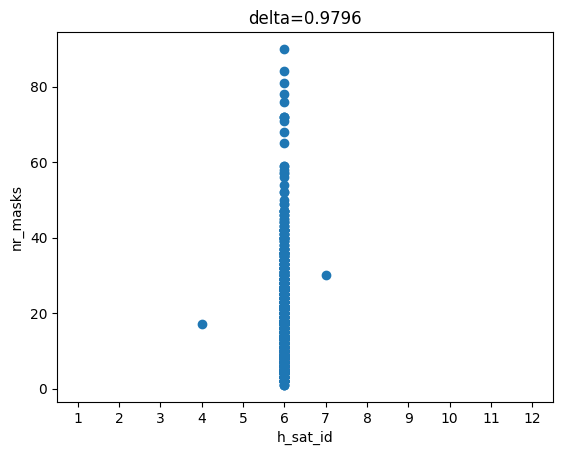

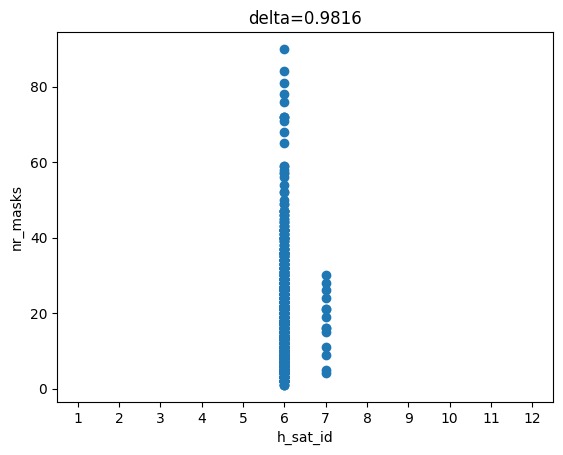

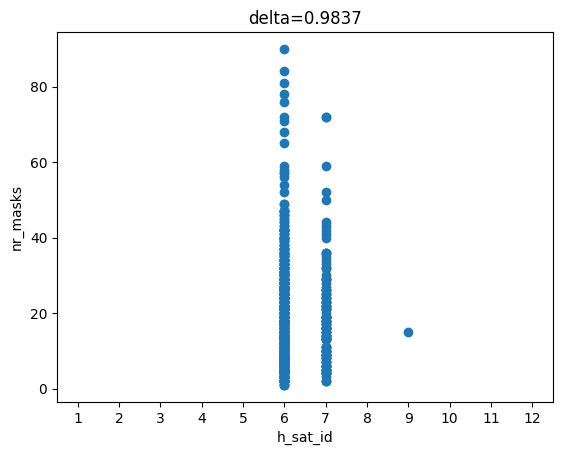

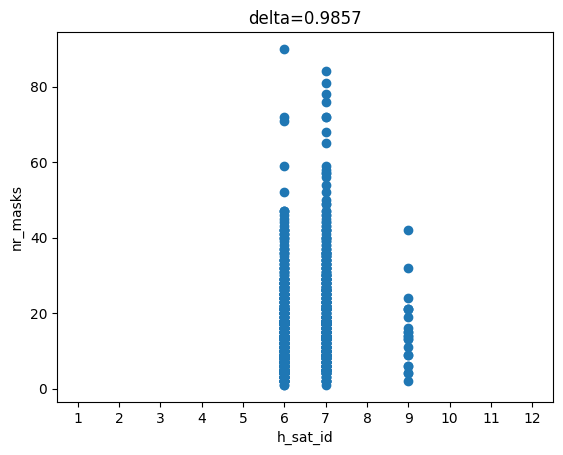

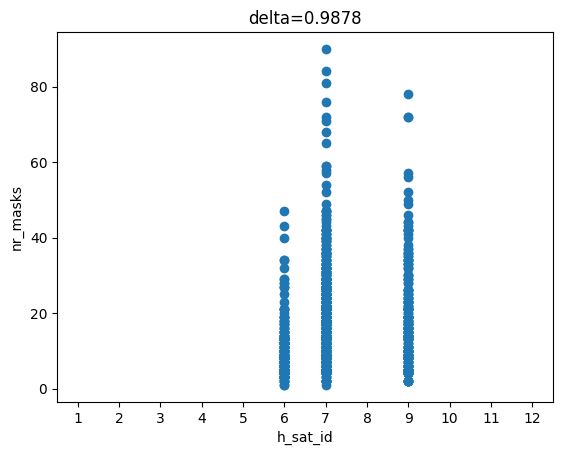

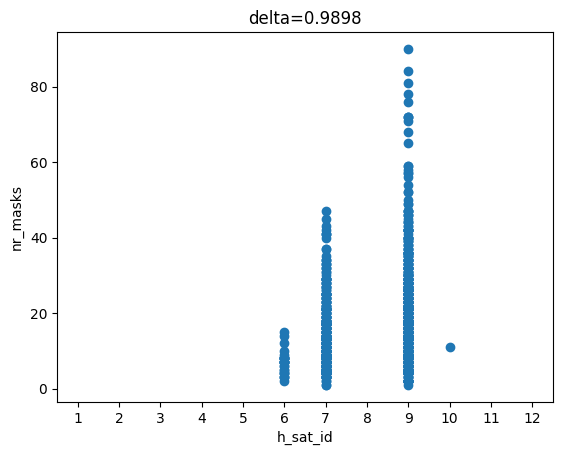

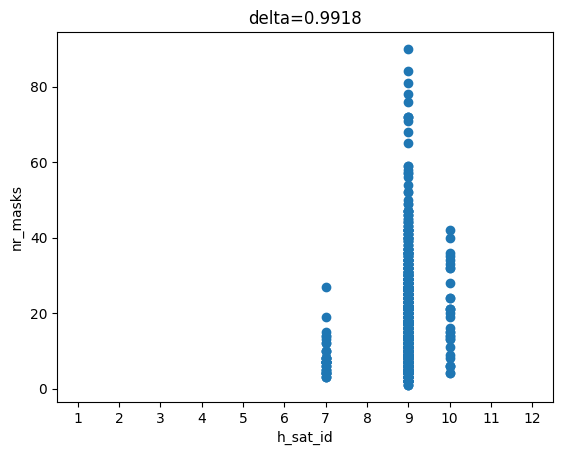

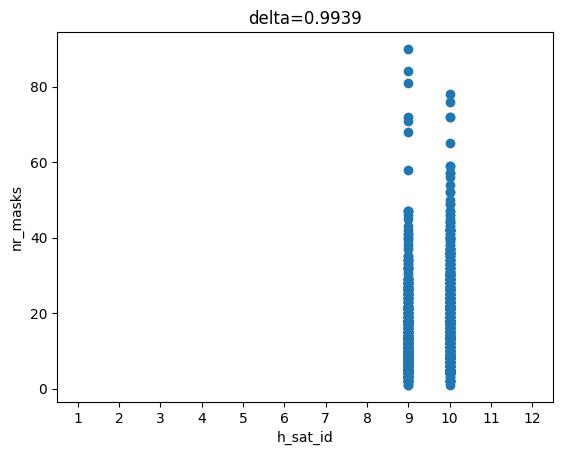

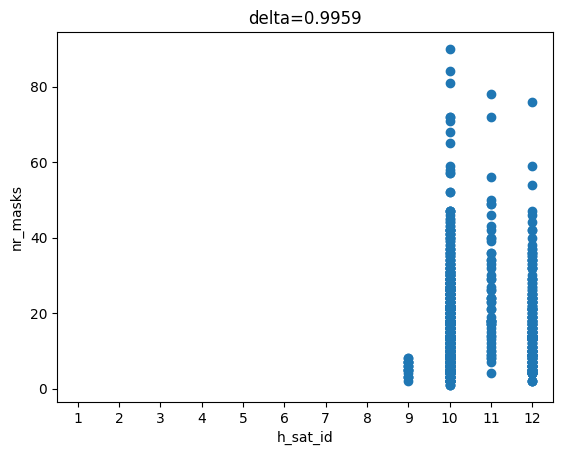

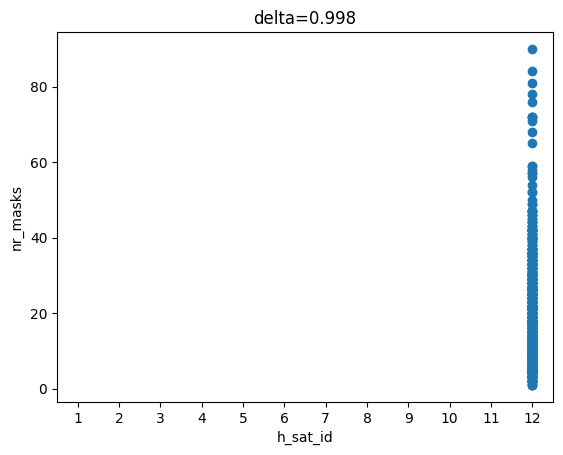

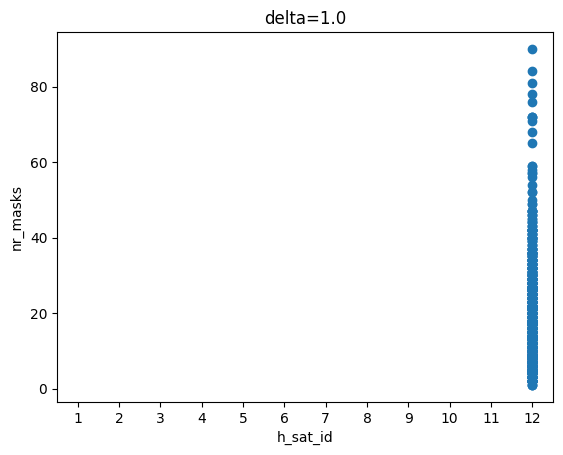

In [59]:
AGG_TYPE = "mean"

for delta in np.linspace(0.9, 1.0, 50):
    delta = round(delta, 4)

    h_sat_id = [find_first_above_threshold(cos_sim_all[n], delta=[delta], agg_type=AGG_TYPE) for n in range(len(cos_sim_all))]

    plt.scatter(h_sat_id, masks_all)

    # Adding labels and title for clarity
    plt.ylabel('nr_masks')
    plt.xlabel('h_sat_id')
    plt.xlim(0.5, len(cos_sim_all[0]) + 1.5)
    plt.xticks(range(1, len(cos_sim_all[0]) + 2, 1))
    plt.title(f'delta={delta}')

    # Show the plot
    plt.show()

## 3.2) Dynamic threshold

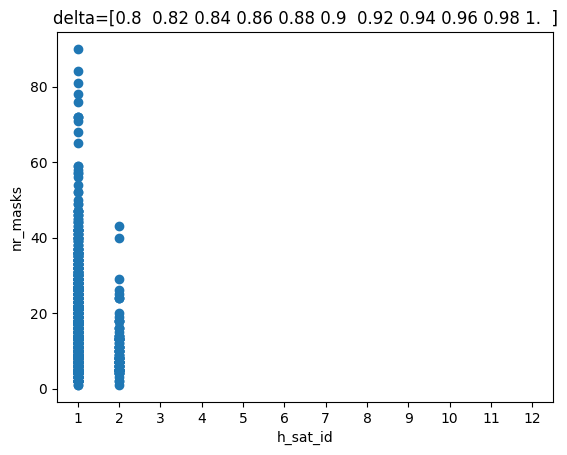

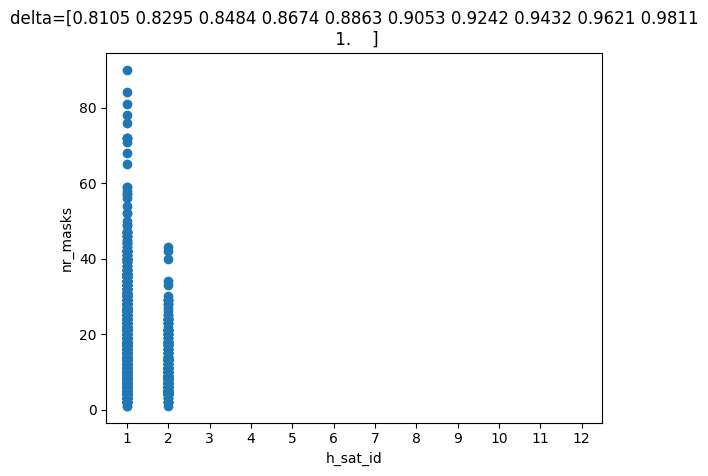

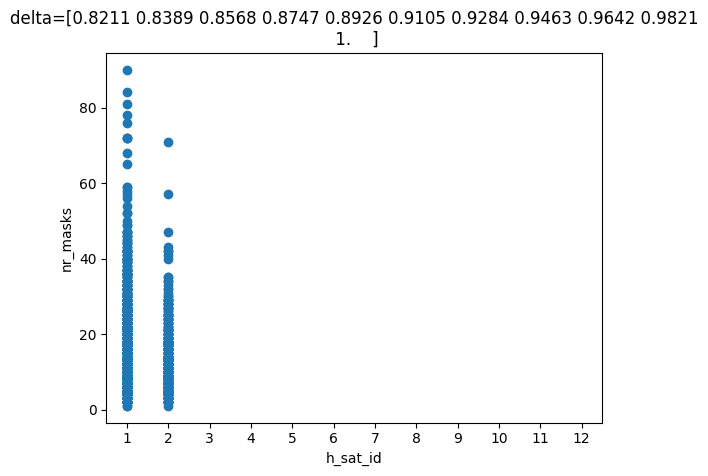

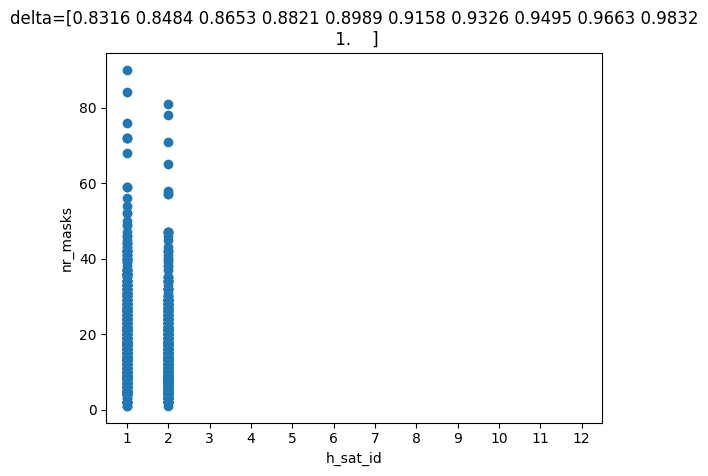

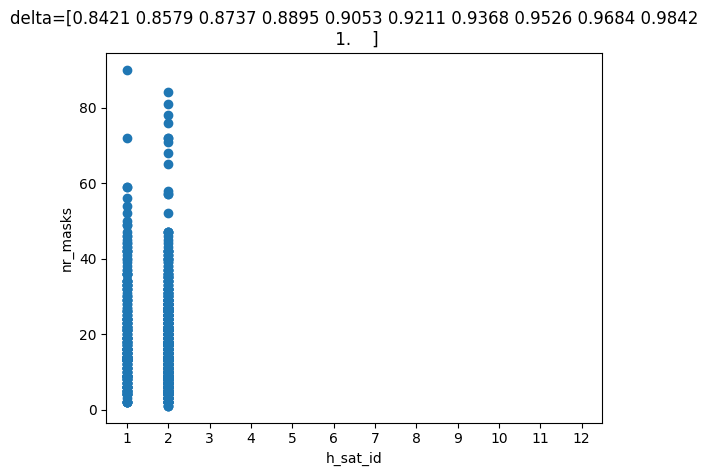

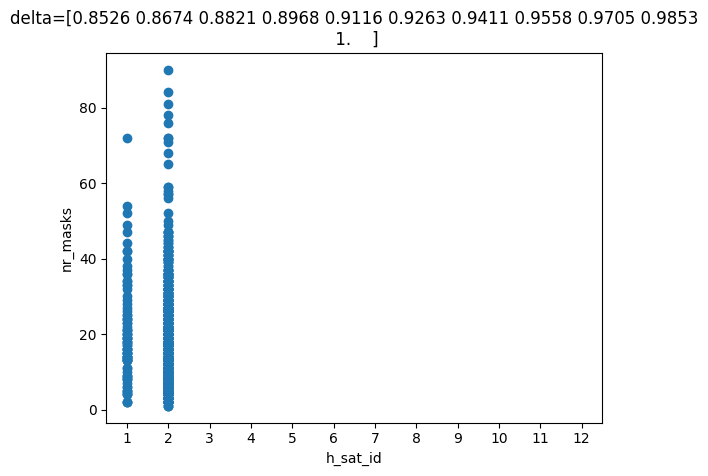

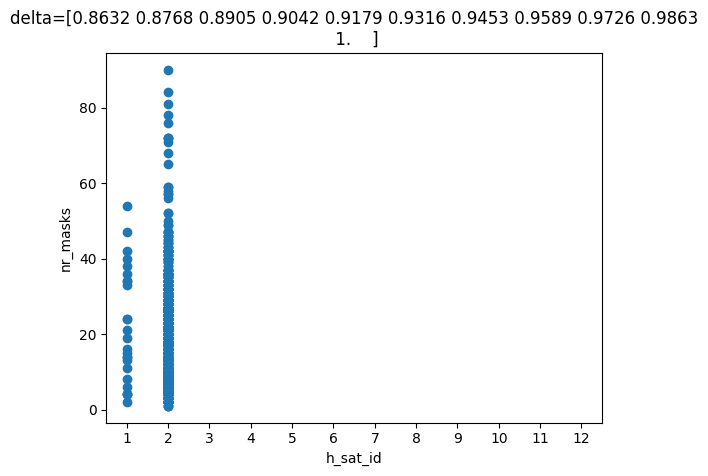

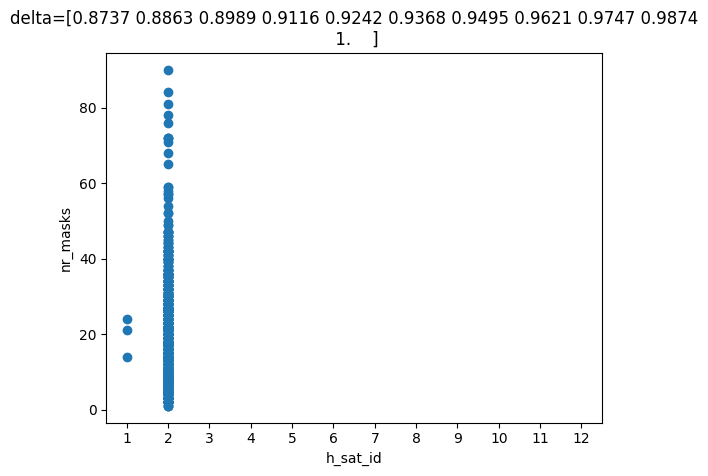

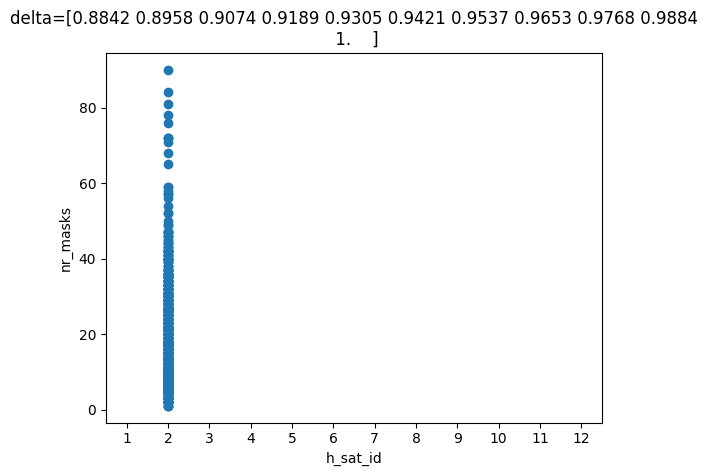

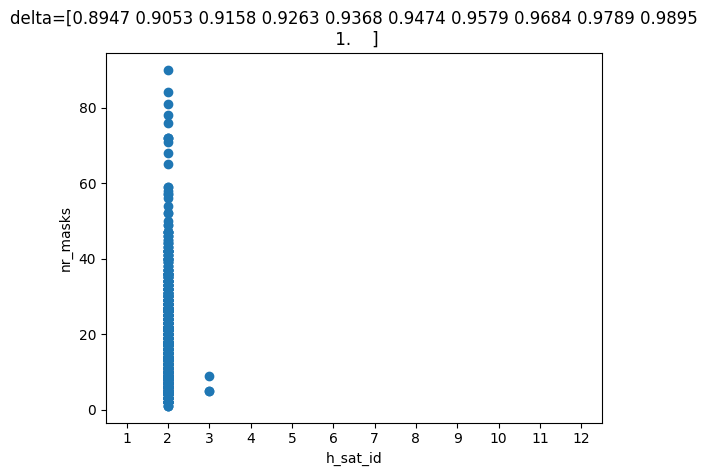

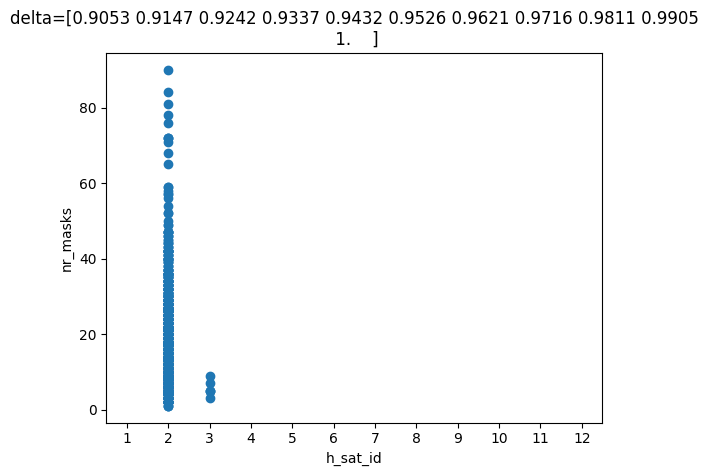

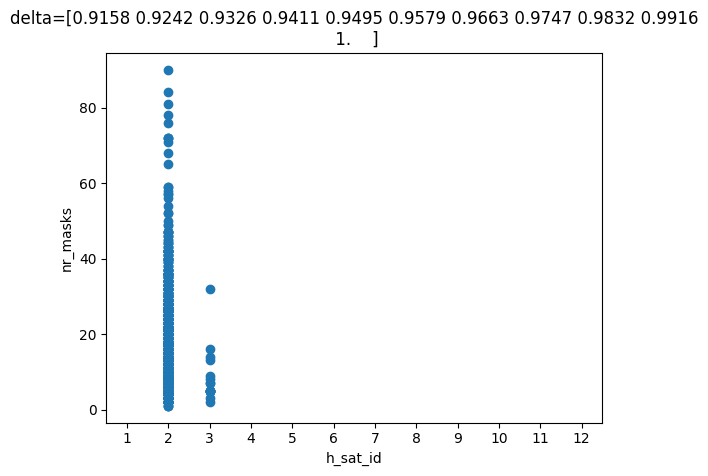

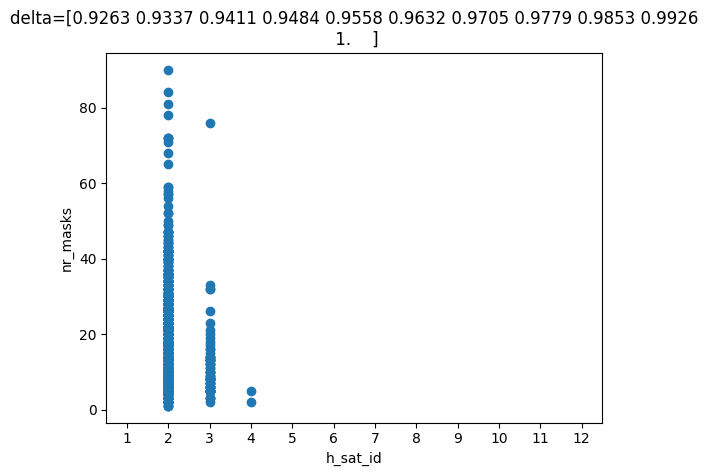

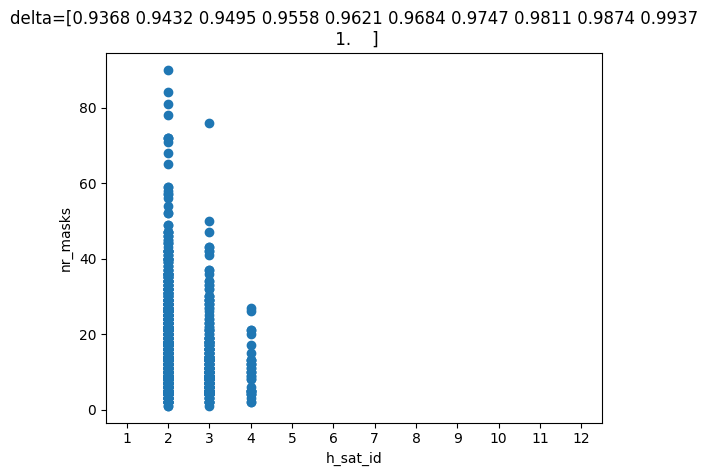

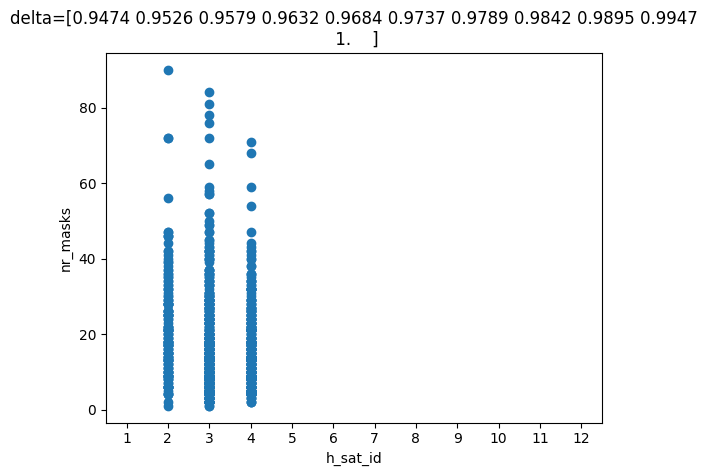

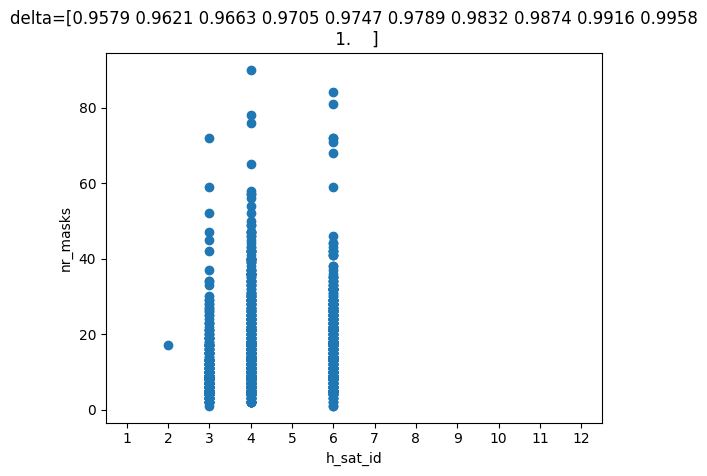

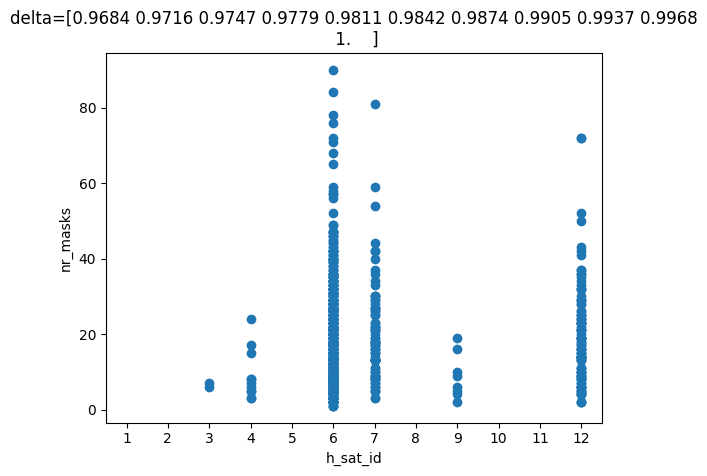

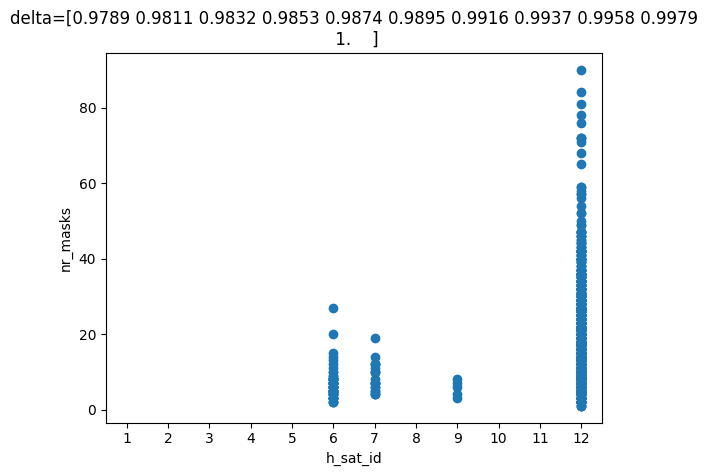

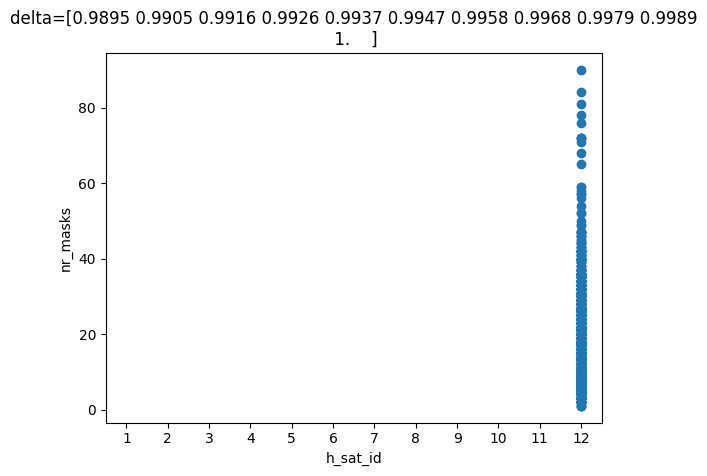

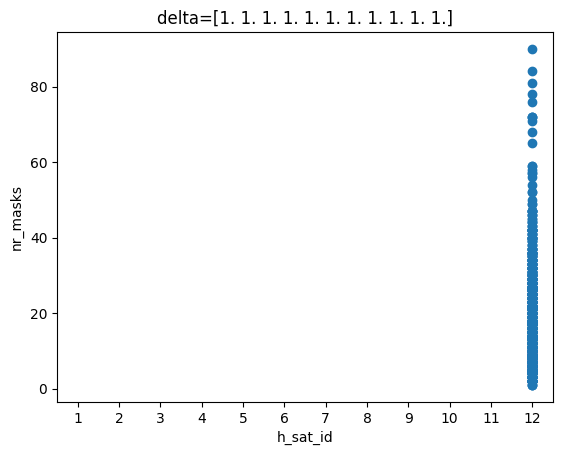

In [61]:
AGG_TYPE = "mean"

for delta in np.linspace(0.8, 1.0, 20):
    delta = np.linspace(delta, 1.0, len(cos_sim_all[0])).round(4)

    h_sat_id = [find_first_above_threshold(cos_sim_all[n], delta=delta, agg_type=AGG_TYPE) for n in range(len(cos_sim_all))]

    plt.scatter(h_sat_id, masks_all)

    # Adding labels and title for clarity
    plt.ylabel('nr_masks')
    plt.xlabel('h_sat_id')
    plt.xlim(0.5, len(cos_sim_all[0]) + 1.5)
    plt.xticks(range(1, len(cos_sim_all[0]) + 2, 1))
    plt.title(f'delta={delta}')

    # Show the plot
    plt.show()